In [1]:
from pathlib import Path

import numpy as np

from model.enums import Direction, ElementType
from model.validation import (Regular2DFrameInput, BasicSectionCollectionInput,
                              SimpleMaterialInput, NTC2018HazardInput)
from src.steel import Steel   # does not see the package
from src.concrete import Concrete
from src.sections import BasicSection
from src.frame import RegularFrameBuilder
from src.elements import BasicElement
from src.subassembly import SubassemblyFactory
from src.hazard import NTC2018SeismicHazard
from src.frame.regular_frame import RegularFrame

from src.scripts import convert_to_section_collection
from src.utils import export_to_json, import_from_json
from src.performance import compute_ISV, compute_ISD
from src.capacity import (column_sidesway, beam_sidesway, mixed_sidesway,
                          mixed_sidesway_sub_stiff, damaged_sidesway_sub_stiff, damaged_mixed_sidesway)

ImportError: cannot import name 'BasicSection' from 'src.sections' (c:\Users\michele.matteoni\VSCProjects\slama_school\SLaMA_school\src\sections\__init__.py)

In [2]:
# Import frame data
frame_dct = import_from_json(Path('./Inputs/Frame.json'))
# print(frame_dct)
# Validate frame data
validated_frame = Regular2DFrameInput(
    **frame_dct
)
# Import section data
sections_dct = import_from_json(Path('./Inputs/Sections.json'))
# validate section data
validated_sections = BasicSectionCollectionInput(
    **sections_dct
)
# Import material data
materials_dct = import_from_json(Path('./Inputs/Materials.json'))
# Validate material data
validated_materials = SimpleMaterialInput(
    **materials_dct
)

In [3]:
 # -o-o-o-o-o- MODEL BUILDING -o-o-o-o-o-

# Instansiate material objects
steel = Steel(**validated_materials.steel.__dict__)
concrete = Concrete(**validated_materials.concrete.__dict__)
# Instanciate Section Data and visitors
sections = convert_to_section_collection(
    validated_sections,
    concrete,
    steel,
    section_type=BasicSection
)
# Build frame model
frame_builder = RegularFrameBuilder(
    frame_data=validated_frame,
    sections=sections,
    element_object=BasicElement
)
frame_builder.build_frame()
frame = frame_builder.get_frame()
# Get subassemblies
subassemly_factory = SubassemblyFactory(frame=frame)

{'beam_equivalent': np.float64(221.5322132277796), 'rotation_yielding': np.float64(0.0025735374682920235), 'rotation_ultimate': np.float64(0.029772546812646003), 'element': <ElementType.LeftBeam: 'leftbeam'>}


(0.0, 2000.0)

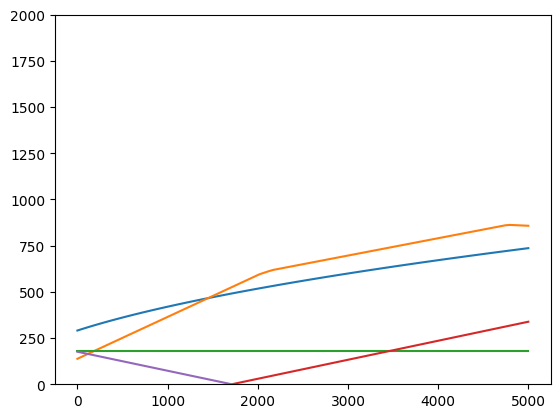

In [13]:
import matplotlib.pyplot as plt
subassembly = subassemly_factory.get_subassembly(13)

print(subassembly.get_hierarchy(Direction.Negative))

axials = np.linspace(0, 5000, 100)

joint_capacity = [subassembly.domain_MN(ax) for ax in axials]
column_capacity = [(subassembly.above_column.get_section().domain_MN(ax) + subassembly.below_column.get_section().domain_MN(ax))/2 for ax in axials]
beam_capacity = [subassembly.left_beam.get_section().moment_curvature().mom_y/2] * 100
delta_axial_pos = [subassembly.delta_axial_moment(axial) for axial in axials]

delta_axial_neg = [subassembly.delta_axial_moment(axial, direction=Direction.Negative) for axial in axials]

plt.plot(
    axials,
    joint_capacity,
    label='join'
)
plt.plot(
    axials,
    column_capacity,
    label='join'
)
plt.plot(
    axials,
    beam_capacity,
    label='join'
)
plt.plot(
    axials,
    delta_axial_pos,
    label='join'
)
plt.plot(
    axials,
    delta_axial_neg,
    label='join'
)
plt.ylim(0, 2000)

In [5]:
# Compute capacity
beam_SLaMA = beam_sidesway(
    sub_factory=subassemly_factory,
    frame=frame
)
# print(beam_SLaMA)
column_SLaMA = column_sidesway(
    sub_factory=subassemly_factory,
    frame=frame
)
# print(column_SLaMA)
classic_SLaMA = mixed_sidesway(
    sub_factory=subassemly_factory,
    frame=frame
)
print(classic_SLaMA)
print(frame.forces_effective_height)

FrameCapacity(name='Mixed Sidesway', mass=np.float64(1249.6782223050138), disp=[np.float64(0.05265598812389821), np.float64(0.08727680347429527)], base_shear=[np.float64(1150.4866622370614), np.float64(1150.4866622370614)])
32.90653766086163


c:\Users\michele.matteoni\VSCProjects\slama_school\SLaMA_school\src\utils.py:53: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  return fsolve(difference_function, initial_guess)[0]
c:\Users\michele.matteoni\VSCProjects\slama_school\SLaMA_school\src\utils.py:53: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  return fsolve(difference_function, initial_guess)[0]


In [6]:
height_ratio = frame.get_heights()[-1]/frame.forces_effective_height

base_shear = np.array([0] + classic_SLaMA.base_shear) * 2.33
displacements = np.array([0] + classic_SLaMA.disp) * height_ratio

(0.0, 2814.665619162971)

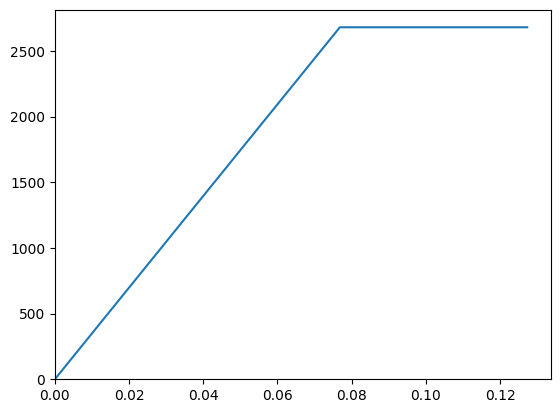

In [7]:
from turtle import left
import matplotlib.pyplot as plt

plt.plot(
       displacements,
       base_shear 
)
plt.xlim(left=0)
plt.ylim(bottom=0)

In [8]:
node_count = frame.get_nodes()

In [9]:
subs = [subassemly_factory.get_subassembly(i) for i in node_count]

In [10]:
from model.enums import NodeType

for i, sub in enumerate(subs):
    if sub.node_type is NodeType.Base:
        continue
    print(sub.get_hierarchy().get('rotation_yielding'))

0.0025805307766297737
0.002524584309927773
0.002524584309927773
0.002524584309927773
0.002524584309927773
0.0025735374682920235
0.001600167986877762
0.0025805307766297737
0.002524584309927773
0.002524584309927773
0.002524584309927773
0.002524584309927773
0.0025735374682920235
0.001605236866660754
0.0028435246564277594
0.0028052022217050134
0.0028052022217050134
0.0028052022217050134
0.0028052022217050134
0.0028435246564277594
0.0026522633396980117
0.002822526232284481
0.002784486795191698
0.002784486795191698
0.002784486795191698
0.002784486795191698
0.002822526232284481
0.0026695430518166685
0.002847358164352856
0.0028094943589758235
0.0028094943589758235
0.0028094943589758235
0.0028094943589758235
0.002847358164352856
0.00275314345605107
0.002829429815022643
0.002791804418546278
0.002791804418546278
0.002791804418546278
0.002791804418546278
0.002829429815022643
0.002876945847947861
0.0028502257199491746
0.002812821182941967
0.002812821182941967
0.002812821182941967
0.0028128211829419